In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import esm
from captum.attr import (
    IntegratedGradients,
    LayerIntegratedGradients,
    TokenReferenceBase,
)
import pandas as pd
from typing import List, Tuple, Dict, Optional, Union
import re
import os
from scipy.stats import entropy

In [2]:
!pip install fair-esm captum

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.1/93.1 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 36.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.

In [4]:
class ESMModelInterpreter:
    """
    A class for interpreting ESM-2 models using integrated gradients and attention visualization.
    This utility works with models trained using the ESM-2 architecture for protein classification.
    """

    def __init__(
        self,
        model_path: str,
        device: str = "cuda" if torch.cuda.is_available() else "cpu",
    ):
        """
        Initialize the interpreter with a saved model.

        Args:
            model_path: Path to the saved model checkpoint
            device: Device to run the model on ('cuda' or 'cpu')
        """
        self.device = device
        self.checkpoint = torch.load(
            model_path, map_location=device, weights_only=False
        )

        # Load the ESM model first
        self.esm_model_name = self.checkpoint.get("esm_model_name", "esm2_t6_8M_UR50D")
        self.esm_model, self.alphabet = self._load_esm_model(self.esm_model_name)
        self.batch_converter = self.alphabet.get_batch_converter()

        # Then recreate the full classifier
        self.model = self._recreate_model()
        self.model.load_state_dict(self.checkpoint["model_state_dict"])
        self.model.to(device)
        self.model.eval()

        # For token reference
        self.ref_token_id = self.alphabet.cls_idx

    def _load_esm_model(self, model_name: str):
        """Load the correct ESM model based on the name saved in the checkpoint."""
        if model_name == "esm2_t6_8M_UR50D":
            return esm.pretrained.esm2_t6_8M_UR50D()
        elif model_name == "esm2_t12_35M_UR50D":
            return esm.pretrained.esm2_t12_35M_UR50D()
        elif model_name == "esm2_t30_150M_UR50D":
            return esm.pretrained.esm2_t30_150M_UR50D()
        elif model_name == "esm2_t33_650M_UR50D":
            return esm.pretrained.esm2_t33_650M_UR50D()
        else:
            raise ValueError(f"Unknown ESM model: {model_name}")

    def _recreate_model(self):
        """Recreate the model architecture from saved hyperparameters."""
        architecture = self.checkpoint.get("model_architecture", {})
        hidden_dim = architecture.get("hidden_dim", 128)
        num_layers = architecture.get("num_layers", 1)
        dropout = architecture.get("dropout", 0.3)

        from torch import nn

        class ESMClassifier(nn.Module):
            def __init__(self, esm_model, hidden_dim=128, num_layers=1, dropout=0.3):
                super().__init__()
                self.esm = esm_model
                layers = []
                input_dim = esm_model.embed_dim

                for _ in range(num_layers):
                    layers.append(nn.Linear(input_dim, hidden_dim))
                    layers.append(nn.ReLU())
                    layers.append(nn.Dropout(dropout))
                    input_dim = hidden_dim

                layers.append(nn.Linear(hidden_dim, 1))
                self.classifier = nn.Sequential(*layers)

            def forward(self, tokens):
                results = self.esm(tokens, repr_layers=[6], return_contacts=False)
                embeddings = results["representations"][6]
                cls_rep = embeddings[:, 0, :]  # CLS token
                logits = self.classifier(cls_rep)
                return logits.squeeze(-1)

        return ESMClassifier(
            self.esm_model,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout,
        )

    def predict(self, sequence: str) -> float:
        """
        Make a prediction for a single protein sequence.

        Args:
            sequence: A protein sequence string

        Returns:
            Predicted probability (0-1)
        """
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        with torch.no_grad():
            output = self.model(tokens)
            prob = torch.sigmoid(output).item()

        return prob

    def _get_attention_weights(self, sequence: str) -> torch.Tensor:
        """
        Extract attention weights from the ESM model for a sequence.

        Args:
            sequence: A protein sequence string

        Returns:
            Tensor of attention weights
        """
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        attention_weights = None

        def hook_fn(module, input, output):
            nonlocal attention_weights
            attention_weights = output.attentions

        # Get number of attention layers
        num_layers = self.esm_model.num_layers

        # Register hook to the last attention layer
        hook = self.esm_model.layers[num_layers - 1].attention.register_forward_hook(
            hook_fn
        )

        # Forward pass
        with torch.no_grad():
            self.model(tokens)

        # Remove hook
        hook.remove()

        return attention_weights

    def visualize_attention(
        self,
        sequence: str,
        layer: int = -1,
        head: int = 0,
        save_path: Optional[str] = None,
    ):
        """
        Visualize attention weights for a sequence.

        Args:
            sequence: Protein sequence to visualize
            layer: Attention layer to visualize (-1 for last layer)
            head: Attention head to visualize
            save_path: Path to save the visualization
        """
        # Get tokens and attention weights
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        with torch.no_grad():
            outputs = self.esm_model(
                tokens,
                repr_layers=[layer],
                return_contacts=False,
                need_head_weights=True,
            )

        # Get attention weights
        attentions = outputs["attentions"]
        if attentions is None:
            print("Attention weights not available. Try using a different ESM model.")
            return

        # Convert layer index
        layer_idx = layer if layer >= 0 else attentions.shape[1] + layer

        # Select the attention correct layer and head
        attention = attentions[0, layer_idx, head].cpu().numpy()

        # Convert tokens to amino acids for visualization
        amino_acids = []
        for token_idx in tokens[0]:
            amino_acid = self.alphabet.get_tok(token_idx.item())
            amino_acids.append(amino_acid)

        # Filter out special tokens and their attention
        valid_tokens = []
        for i, aa in enumerate(amino_acids):
            if aa not in ["<cls>", "<pad>", "<eos>", "<unk>", "<mask>"]:
                valid_tokens.append(aa)

        valid_token_indices = []
        for i, aa in enumerate(amino_acids):
            if aa not in ["<cls>", "<pad>", "<eos>", "<unk>", "<mask>"]:
                valid_token_indices.append(i)

        # Filter attention weights using valid_token_indices
        filtered_attention = attention[np.ix_(valid_token_indices, valid_token_indices)]

        # Plot with seaborn heatmap
        plt.figure(figsize=(10, 8))
        ax = sns.heatmap(
            filtered_attention,
            xticklabels=valid_tokens,
            yticklabels=valid_tokens,
            cmap="viridis",
        )
        plt.title(f"Attention Weights (Layer {layer}, Head {head})")
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

        # Return entropy of each residue's attention distribution
        entropies = [
            entropy(filtered_attention[i]) for i in range(len(filtered_attention))
        ]
        return entropies, filtered_attention, valid_tokens

    def plot_top_attention_residues(
        filtered_attention, valid_amino_acids, top_k=10, mode="received"
    ):
        """
        Plot top residues based on total attention received or sent.

        Args:
            filtered_attention (np.ndarray): Attention matrix (filtered).
            valid_amino_acids (list): List of amino acids (after filtering).
            top_k (int): Number of top residues to show.
            mode (str): 'received' or 'sent' to indicate direction of attention.
        """
        if mode == "received":
            scores = filtered_attention.sum(axis=0)  # attention received
        else:
            scores = filtered_attention.sum(axis=1)  # attention sent

        # Get top indices
        top_indices = np.argsort(scores)[-top_k:][::-1]
        top_residues = [valid_amino_acids[i] for i in top_indices]
        top_scores = scores[top_indices]

        # Plot
        plt.figure(figsize=(10, 5))
        bars = plt.bar(range(top_k), top_scores, color="darkcyan")
        plt.xticks(
            range(top_k),
            [f"{aa}-{i}" for aa, i in zip(top_residues, top_indices)],
            rotation=45,
        )
        plt.ylabel("Total Attention " + ("Received" if mode == "received" else "Sent"))
        plt.title(f"Top {top_k} Residues by Attention {mode.capitalize()}")
        plt.tight_layout()
        plt.show()

        return top_residues, top_scores

    def integrated_gradients_attributions(
        self,
        sequence: str,
        n_steps: int = 50,
        internal_batch_size: int = 5,
        save_path: Optional[str] = None,
    ) -> Tuple[np.ndarray, list, float]:
        """
        Compute attributions using embedding-level integrated gradients.
        This works by accessing the embedding layer of the ESM model directly.

        Args:
            sequence: Protein sequence to analyze
            n_steps: Number of steps in integral approximation
            internal_batch_size: Batch size for internal processing
            save_path: Path to save the visualization

        Returns:
            Tuple of (attributions, amino_acids, prediction)
        """
        # Prepare input
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        # Extract the embedding layer
        embedding_layer = self.esm_model.embed_tokens

        # Create a wrapper model that exposes embeddings
        class EmbeddingModel(torch.nn.Module):
            def __init__(self, embedding_layer, model):
                super().__init__()
                self.embedding_layer = embedding_layer
                self.model = model

            def forward(self, embeddings):
                # Replace the embedding lookup in the original model with our input
                def hook_fn(module, input, output):
                    return embeddings

                # Register hook to override embeddings
                handle = self.embedding_layer.register_forward_hook(hook_fn)

                # Use a dummy input for token IDs - the hook will replace embeddings
                dummy_input = torch.zeros_like(tokens)
                output = self.model(dummy_input)

                # Remove hook
                handle.remove()

                return output

        embedding_model = EmbeddingModel(embedding_layer, self.model)

        # Get original embeddings
        with torch.no_grad():
            original_embeddings = embedding_layer(tokens)
            # Create a baseline of all zeros for the embedding
            baseline_embeddings = torch.zeros_like(original_embeddings)

        # Now we can use regular integrated gradients on the embeddings
        integrated_gradients = IntegratedGradients(embedding_model)

        # Get a regular prediction for comparison
        with torch.no_grad():
            pred = torch.sigmoid(self.model(tokens)).item()
            print(f"Regular prediction: {pred:.4f}")

        # Compute attributions on the embeddings
        attributions = integrated_gradients.attribute(
            original_embeddings,
            baselines=baseline_embeddings,
            n_steps=n_steps,
            internal_batch_size=internal_batch_size,
        )

        # Sum across embedding dimensions to get token-level attributions
        token_attributions = attributions.sum(dim=2).squeeze(0)
        token_attributions = token_attributions.cpu().detach().numpy()

        # Normalize attributions for visualization
        attr_sum = np.sum(np.abs(token_attributions))
        if attr_sum > 0:  # avoid division by zero
            norm_attributions = token_attributions / attr_sum
        else:
            norm_attributions = token_attributions

        # Convert tokens to amino acids
        amino_acids = []
        for token_idx in tokens[0]:
            amino_acid = self.alphabet.get_tok(token_idx.item())
            amino_acids.append(amino_acid)

        # Filter out special tokens
        valid_attributions = []
        valid_amino_acids = []
        for i, aa in enumerate(amino_acids):
            if aa not in ["<cls>", "<pad>", "<eos>", "<unk>", "<mask>"]:
                valid_attributions.append(norm_attributions[i])
                valid_amino_acids.append(aa)

        # Visualize attributions
        plt.figure(figsize=(15, 5))

        # Create bar plot with colors
        colors = ["red" if x < 0 else "blue" for x in valid_attributions]
        bars = plt.bar(range(len(valid_attributions)), valid_attributions, color=colors)

        # Add amino acid labels
        if (
            len(valid_amino_acids) <= 100
        ):  # Only show labels if sequence is not too long
            plt.xticks(
                range(len(valid_attributions)), valid_amino_acids, rotation="vertical"
            )
        else:
            plt.xticks([])  # Remove x-axis labels if too many

        plt.xlabel("Amino Acid Position")
        plt.ylabel("Attribution Score")
        plt.title(f"Integrated Gradients Attribution (Prediction: {pred:.4f})")
        plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

        # Return the processed attributions and prediction
        return valid_attributions, valid_amino_acids, pred

    def integrated_gradients_attributions(
        self,
        sequence: str,
        n_steps: int = 50,
        internal_batch_size: int = 5,
        save_path: Optional[str] = None,
    ) -> Tuple[np.ndarray, list, float]:
        """
        Compute attributions using embedding-level integrated gradients.
        This works by accessing the embedding layer of the ESM model directly.

        Args:
            sequence: Protein sequence to analyze
            n_steps: Number of steps in integral approximation
            internal_batch_size: Batch size for internal processing
            save_path: Path to save the visualization

        Returns:
            Tuple of (attributions, amino_acids, prediction)
        """
        # Prepare input
        batch_labels = [("protein", sequence)]
        _, _, tokens = self.batch_converter(batch_labels)
        tokens = tokens.to(self.device)

        # Extract the embedding layer
        embedding_layer = self.esm_model.embed_tokens

        # Create a wrapper model that exposes embeddings
        class EmbeddingModel(torch.nn.Module):
            def __init__(self, embedding_layer, model):
                super().__init__()
                self.embedding_layer = embedding_layer
                self.model = model

            def forward(self, embeddings):
                # Replace the embedding lookup in the original model with our input
                def hook_fn(module, input, output):
                    return embeddings

                # Register hook to override embeddings
                handle = self.embedding_layer.register_forward_hook(hook_fn)

                # Use a dummy input for token IDs - the hook will replace embeddings
                dummy_input = torch.zeros_like(tokens)
                output = self.model(dummy_input)

                # Remove hook
                handle.remove()

                return output

        embedding_model = EmbeddingModel(embedding_layer, self.model)

        # Get original embeddings
        with torch.no_grad():
            original_embeddings = embedding_layer(tokens)
            # Create a baseline of all zeros for the embedding
            baseline_embeddings = torch.zeros_like(original_embeddings)

        # Now we can use regular integrated gradients on the embeddings
        integrated_gradients = IntegratedGradients(embedding_model)

        # Get a regular prediction for comparison
        with torch.no_grad():
            pred = torch.sigmoid(self.model(tokens)).item()
            print(f"Regular prediction: {pred:.4f}")

        # Compute attributions on the embeddings
        attributions = integrated_gradients.attribute(
            original_embeddings,
            baselines=baseline_embeddings,
            n_steps=n_steps,
            internal_batch_size=internal_batch_size,
        )

        # Sum across embedding dimensions to get token-level attributions
        token_attributions = attributions.sum(dim=2).squeeze(0)
        token_attributions = token_attributions.cpu().detach().numpy()

        # Normalize attributions for visualization
        attr_sum = np.sum(np.abs(token_attributions))
        if attr_sum > 0:  # avoid division by zero
            norm_attributions = token_attributions / attr_sum
        else:
            norm_attributions = token_attributions

        # Convert tokens to amino acids
        amino_acids = []
        for token_idx in tokens[0]:
            amino_acid = self.alphabet.get_tok(token_idx.item())
            amino_acids.append(amino_acid)

        # Filter out special tokens
        valid_attributions = []
        valid_amino_acids = []
        for i, aa in enumerate(amino_acids):
            if aa not in ["<cls>", "<pad>", "<eos>", "<unk>", "<mask>"]:
                valid_attributions.append(norm_attributions[i])
                valid_amino_acids.append(aa)

        # Visualize attributions
        plt.figure(figsize=(15, 5))

        # Create bar plot with colors
        colors = ["red" if x < 0 else "blue" for x in valid_attributions]
        bars = plt.bar(range(len(valid_attributions)), valid_attributions, color=colors)

        # Add amino acid labels
        if (
            len(valid_amino_acids) <= 100
        ):  # Only show labels if sequence is not too long
            plt.xticks(
                range(len(valid_attributions)), valid_amino_acids, rotation="vertical"
            )
        else:
            plt.xticks([])  # Remove x-axis labels if too many

        plt.xlabel("Amino Acid Position")
        plt.ylabel("Attribution Score")
        plt.title(f"Integrated Gradients Attribution (Prediction: {pred:.4f})")
        plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path)

        plt.show()

        # Return the processed attributions and prediction
        return valid_attributions, valid_amino_acids, pred

    def get_top_influential_residues(
        self, sequence: str, top_n: int = 10, n_steps: int = 50, absolute: bool = True
    ) -> pd.DataFrame:
        """
        Return the top influential residues based on integrated gradients.

        Args:
            sequence: Protein sequence to analyze
            top_n: Number of top residues to return
            n_steps: Number of steps in integral approximation
            absolute: If True, rank by absolute magnitude; if False, rank by actual value

        Returns:
            DataFrame with position, residue, and attribution score
        """
        # Get attributions
        attributions, amino_acids, pred = self.integrated_gradients_attributions(
            sequence, n_steps=n_steps, save_path=None
        )

        # Create dataframe
        df = pd.DataFrame(
            {
                "Position": range(1, len(attributions) + 1),
                "Residue": amino_acids,
                "Attribution": attributions,
            }
        )

        # Sort by attribution score
        if absolute:
            df["AbsAttribution"] = df["Attribution"].abs()
            df = df.sort_values("AbsAttribution", ascending=False).head(top_n)
            df = df.drop("AbsAttribution", axis=1)
        else:
            df = df.sort_values("Attribution", ascending=False).head(top_n)

        return df

    def process_multiple_sequences(
        self,
        sequences: List[str],
        ids: Optional[List[str]] = None,
        output_dir: str = "attributions",
        n_steps: int = 50,
    ) -> Dict[str, Dict]:
        """
        Process multiple sequences and save attributions.

        Args:
            sequences: List of protein sequences
            ids: List of sequence identifiers (if None, will use indices)
            output_dir: Directory to save attributions
            n_steps: Number of steps for integrated gradients

        Returns:
            Dictionary of results
        """
        if ids is None:
            ids = [f"seq_{i}" for i in range(len(sequences))]

        if len(ids) != len(sequences):
            raise ValueError("Length of ids must match length of sequences")

        # Create output directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)

        results = {}

        for seq_id, sequence in zip(ids, sequences):
            print(f"Processing {seq_id}...")

            # Make prediction
            pred = self.predict(sequence)

            # Get attributions
            attr_path = os.path.join(output_dir, f"{seq_id}_attributions.png")
            attributions, amino_acids, _ = self.integrated_gradients_attributions(
                sequence, n_steps=n_steps, save_path=attr_path
            )

            # Get attention visualization
            attn_path = os.path.join(output_dir, f"{seq_id}_attention.png")
            entropies, attention = self.visualize_attention(
                sequence, save_path=attn_path
            )

            # Get top influential residues
            top_residues = self.get_top_influential_residues(sequence)

            results[seq_id] = {
                "prediction": pred,
                "attributions": attributions,
                "amino_acids": amino_acids,
                "top_residues": top_residues,
                "attention_entropies": entropies,
            }

            # Save top residues to CSV
            top_residues.to_csv(
                os.path.join(output_dir, f"{seq_id}_top_residues.csv"), index=False
            )

        return results

In [5]:
def load_model_for_interpretation(model_path: str) -> ESMModelInterpreter:
    """
    Convenience function to load a saved model for interpretation.

    Args:
        model_path: Path to saved model checkpoint

    Returns:
        ESMModelInterpreter instance
    """
    interpreter = ESMModelInterpreter(model_path)
    return interpreter

Analyzing single sequence...
Prediction: 0.9903
Computing integrated gradients attributions...
Regular prediction: 0.9903


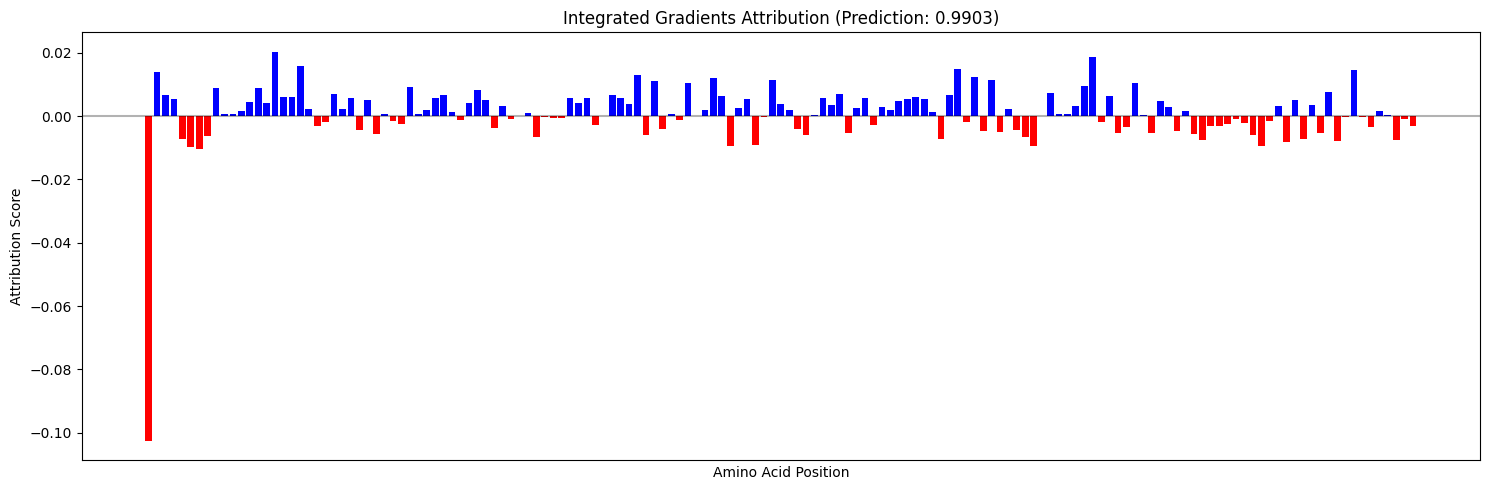

Visualizing attention...


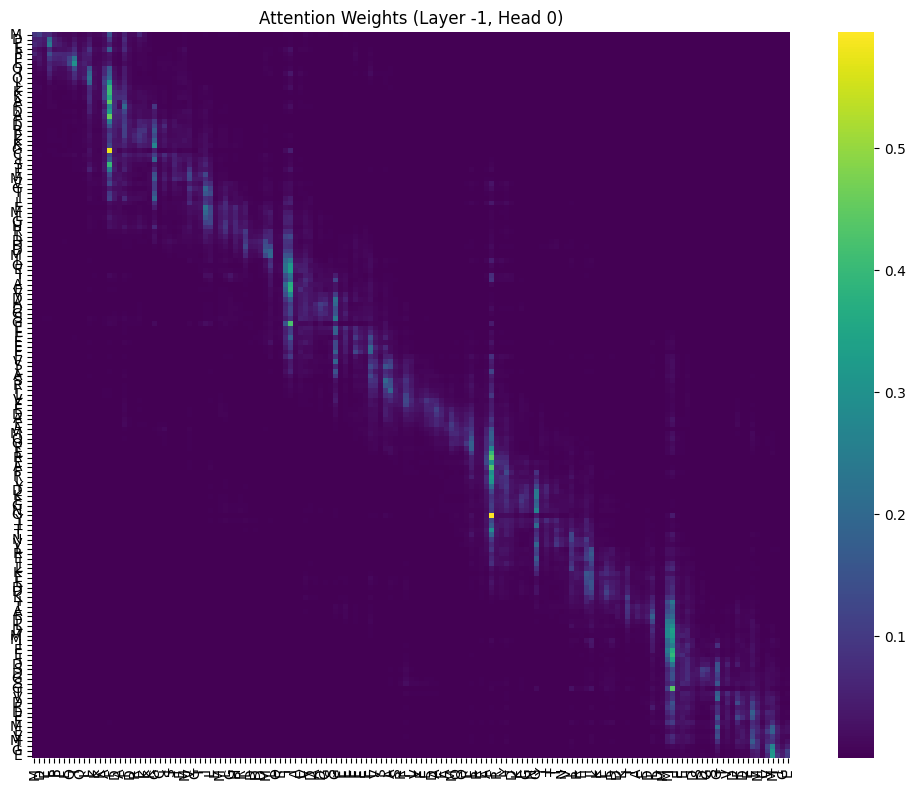

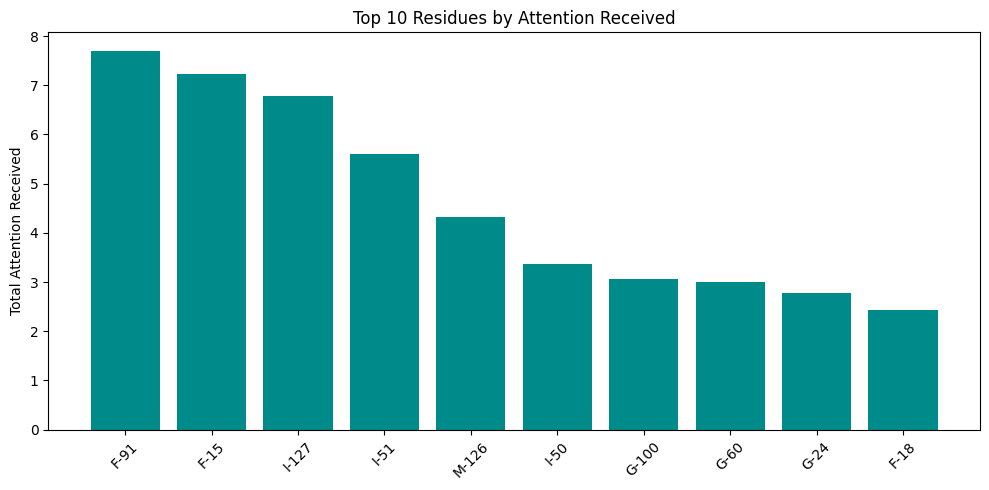

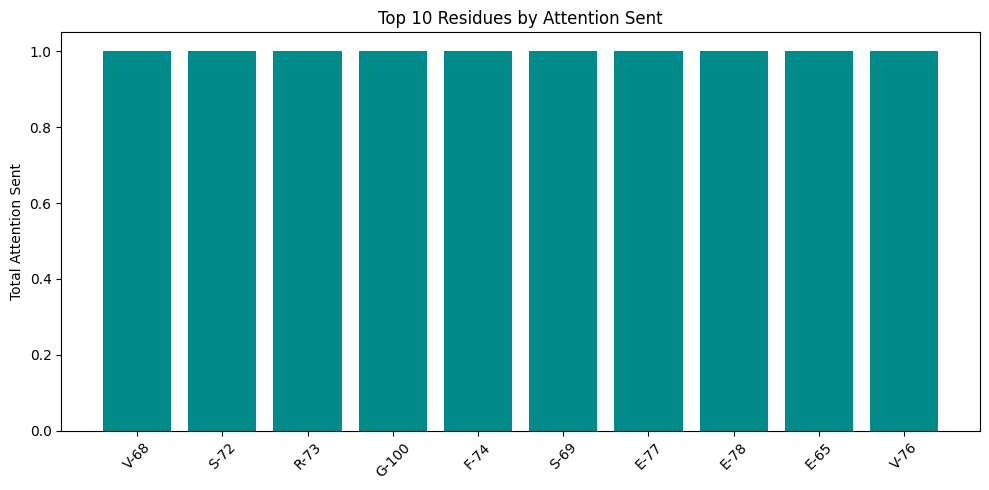

Top influential residues:
Regular prediction: 0.9903


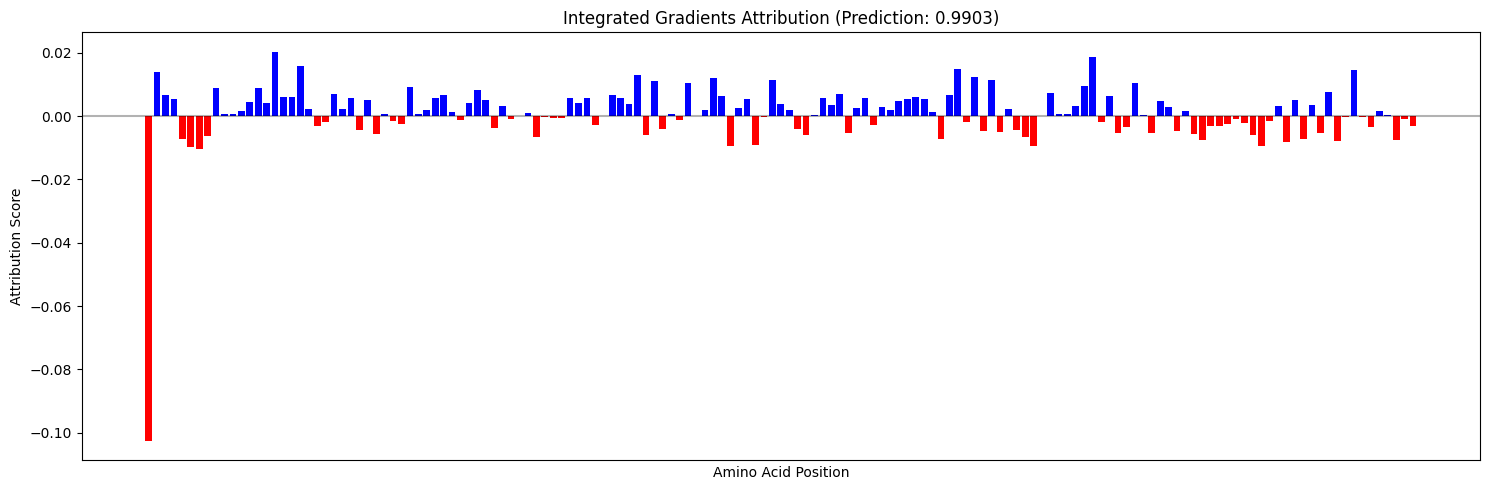

     Position Residue  Attribution
0           1       M    -0.102624
15         16       F     0.020326
112       113       K     0.018671
18         19       F     0.015795
96         97       K     0.014868
143       144       F     0.014434
1           2       D     0.014015
58         59       G     0.013019
98         99       G     0.012250
67         68       F     0.012194
Analysis complete!


In [8]:
# Load the saved model
interpreter = load_model_for_interpretation(
    "fine-tuned_esm2_allergen_classifier-final_version.pt"
)

# Example protein sequence (replace with a real sequence)
example_sequence = "MDELPPEQIQLLKKAFDAFDREKKGCISTEMVGTILEMLGHRLDDDMLQEIIAEVDADGSGELEFEEFVSLASRFLVEEDAEAMQQELREAFRLYDKEGNGYITTNVLREILKELDDKITAEDLDMMIEEIDSDGSGTVDFDEFMEVMTGE"
# Single sequence analysis
print("Analyzing single sequence...")

# Make prediction
pred = interpreter.predict(example_sequence)
print(f"Prediction: {pred:.4f}")

# Get attributions
print("Computing integrated gradients attributions...")
attributions, amino_acids, pred = interpreter.integrated_gradients_attributions(
    example_sequence, save_path="example_attributions.png"
)

# Get attention visualization
print("Visualizing attention...")
entropies, filtered_attention, valid_tokens = interpreter.visualize_attention(
    example_sequence, save_path="example_attention.png"
)
top_residues, top_scores = ESMModelInterpreter.plot_top_attention_residues(
    filtered_attention, valid_tokens, top_k=10, mode="received"
)
top_residues, top_scores = ESMModelInterpreter.plot_top_attention_residues(
    filtered_attention, valid_tokens, top_k=10, mode="sent"
)

# Get top influential residues
print("Top influential residues:")
top_residues = interpreter.get_top_influential_residues(example_sequence)
print(top_residues)


print("Analysis complete!")

In [ ]:
# Process multiple sequences from the test set

# Load the dataset
interpreter = load_model_for_interpretation("fine-tuned_esm2_allergen_classifier.pt")

sequences = [
    example_sequence,
    example_sequence[50:150],  # Just an example using a subsequence
]
ids = ["protein1", "protein2"]

print("\nProcessing multiple sequences...")
results = interpreter.process_multiple_sequences(sequences, ids, output_dir="results")

print("Analysis complete!")